# MATH2319 Machine Learning Project Phase 2

# Contents
* [Phase 1 Summary](#1)
* [Methodology](#2)
* [Data Preparation](#3)
  - [Loading Dataset](#3.1)
  - [Encoding Categorical features & Scaling](#3.2)
* [Feature Importance](#4)
* [Train-test Splitting](#5)
* [Hyper Parameter Testing](#6)
  - [K-Nearest Neighbours (KNN)](#6.1)
  - [(Gaussian) Naive Bayes (NB)](#6.2)
  - [Decision Tree (DT)](#6.3)
* [Performance Comparison](#7)
* [Critique](#8)
* [Summary & Conclusion](#9)

# Phase 1 Summary<a class="anchor" id="1"></a><br>
Through phase 1's preparation of the data, I removed the 4 entries that contained missing values in the `Albumin/Globulin ratio`. Decided that keep the `Gender` data together as no large difference in trends could bee seen however they will be split due to the requirments of the analyitical functions. Lastly I chose to continue with all the variables as there was no clear correlations that could be removed as certain information was missing.

# Methodology<a class="anchor" id="2"></a>
The objective of the report is build and test 3 different binomial classification models: `K-Nearest Neighbours (KNN)`, `Naive Bayes (NB)` and `Decision Tree (DT)` to find which best predicts the target feature.

This report will be working off the data preparations done in phase 1. With further perparations of the categorical feature `Gender` been numerically split followed by scaling the descriptive features to enable further analytical capabilities. Lasty the dataset will be split into test/training with a 70/30 ratio split.

In terms of feature selection I will be testing 3 different models `f_classif`, `Mutual Information` and `Random Forests`to see which best produces an outcome given all or a limited number of features.

Using the training set together with a feature selection method inside a pipeline, we conduct a 3-repeated 5-fold stratified cross-validation to fine-tune hyperparameters of each classifier using **roc_auc** as the performance metric, given the target feature is an unbalanced dataset. 

Lastly through cross-validation and t-tests the best parameters from each model, confusion matrices will be built to best judge which model best predicts the outcome to our needs.

#  Data Preparation<a class="anchor" id="3"></a>
## Loading Dataset<a class="anchor" id="3.1"></a>

We start by reloading the dataset back to its state in phase 1, by reimporting the data and removing the 4 missing varibles.

In [1]:
import pandas as pd
xls = pd.ExcelFile('indian_liver_patient.xlsx')
df = xls.parse(index_col=None)
df.to_csv('file.csv')

In [2]:
import numpy as np
df['Albumin_and_Globulin_Ratio'].replace('', np.nan, inplace=True)
df.dropna(subset=['Albumin_and_Globulin_Ratio'], inplace=True)
print("Missing Values check")
print(df.isnull().sum())

Missing Values check
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64


## Encoding Categorical features & Scaling<a class="anchor" id="3.2"></a>

We then split the dataset into `Data` and `target`, with the target been the `dataset` feature and the rest of the features remaining in Data.<br> 
At this point all of our features are numerical features with the exception of `Gender` thus we need to apply `get_dummies` as this will represent `Gender` through binomial variables 0/1, because further analysis will require all numerical features.<br>
Lastly we scale the Dataset through a `robust` transformation as multiple features contains extreme outliers and this method of scaling works best with outliers.

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Data = df.drop(columns = 'Dataset')
Data_df = Data.copy()
target = df['Dataset']
Data=pd.get_dummies(Data, columns=["Gender"], drop_first=True)
print(Data.head(5))
Data = preprocessing.RobustScaler().fit_transform(Data)
target = preprocessing.LabelEncoder().fit_transform(target)
target = np.abs(target - 1)

   Age  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65              0.7               0.1                   187   
1   62             10.9               5.5                   699   
2   62              7.3               4.1                   490   
3   58              1.0               0.4                   182   
4   72              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Gender_Male  
0      3.3                        0.90            0  
1      3.2                        0.74

# Feature Importance<a class="anchor" id="4"></a><br>

Next we will find the most important features as modelled by the random forest Importance (RFI) as unlike other feature selection methods such as F-score or Mutual Information RFI , then display

In [4]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(333)
num_features = 10
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = Data_df.columns[fs_indices_rfi].values

In [5]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]

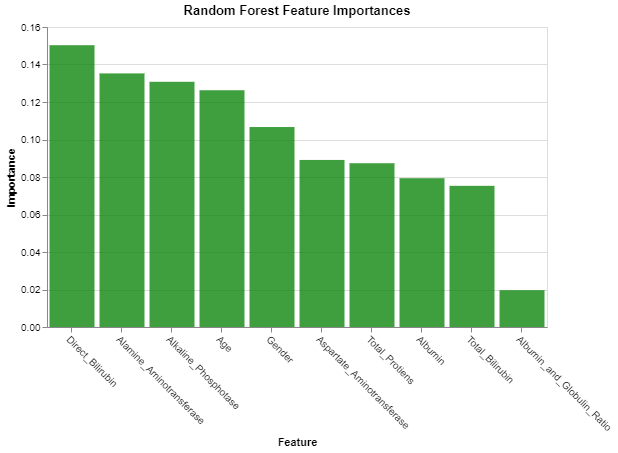

In [6]:
import altair as alt
alt.renderers.enable('notebook')

def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.75, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest', 'green')

We can see that `Direct Bilirubin`, `Alkaline Phosphotase`, `Age` and `Alamine Aminotransferase` are the most important features. 

# Feature Selection

We shall preform some feature selection to see which method preforms the best on the given dataset.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
clf = KNeighborsClassifier(n_neighbors=3)
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3,
                                    random_state=333)
scoring_metric = 'roc_auc'

## F-Score

In [8]:
from sklearn import feature_selection as fs
from sklearn.feature_selection import f_classif

np.random.seed(333)
Results_fscore=[]
best_features_fscore=[]
num_features = [1,2,3,4,5,6,7,8,9,10,Data.shape[1]]
for x in num_features:
    fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=x)
    fs_fit_fscore.fit_transform(Data, target)
    fs_indices_fscore = np.argsort(fs_fit_fscore.scores_)[::-1][0:x]
    best_features_fscore.append(df.columns[fs_indices_fscore].values)
    cv_results_fscore = cross_val_score(clf,
                                 Data[:, fs_indices_fscore],
                                 target, 
                                 cv=cv_method, 
                                 scoring=scoring_metric)
    Results_fscore.append(cv_results_fscore.mean().round(3))
print(max(Results_fscore))
print(best_features_fscore[Results_fscore.index(max(Results_fscore))])

0.717
['Total_Bilirubin' 'Gender' 'Direct_Bilirubin' 'Albumin'
 'Alkaline_Phosphotase' 'Total_Protiens' 'Alamine_Aminotransferase' 'Age'
 'Albumin_and_Globulin_Ratio']


## Mutual Selection

In [9]:
from sklearn.feature_selection import mutual_info_classif

np.random.seed(333)
Results_mutual=[]
best_features_mutual=[]
num_features = [1,2,3,4,5,6,7,8,9,10,Data.shape[1]]
for x in num_features:
    fs_fit_mutual = fs.SelectKBest(fs.mutual_info_classif, k=x)
    fs_fit_mutual.fit_transform(Data, target)
    fs_indices_mutual = np.argsort(fs_fit_mutual.scores_)[::-1][0:x]
    best_features_mutual.append(df.columns[fs_indices_mutual].values)
    cv_results_fscore = cross_val_score(clf,
                                 Data[:, fs_indices_mutual],
                                 target, 
                                 cv=cv_method, 
                                 scoring=scoring_metric)
    Results_mutual.append(cv_results_fscore.mean().round(3))
print(max(Results_mutual))
print(best_features_mutual[Results_mutual.index(max(Results_mutual))])

0.732
['Alamine_Aminotransferase' 'Gender' 'Alkaline_Phosphotase' 'Age'
 'Total_Bilirubin' 'Direct_Bilirubin' 'Total_Protiens'
 'Albumin_and_Globulin_Ratio']


## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(333)
Results_forest=[]
best_features_rfi=[]
num_features = [1,2,3,4,5,6,7,8,9,10,Data.shape[1]]
for x in num_features:
    model_rfi = RandomForestClassifier(n_estimators=100)
    model_rfi.fit(Data, target)
    fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:x]
    best_features_rfi.append(df.columns[fs_indices_rfi].values)
    cv_results_rfi = cross_val_score(clf,
                                 Data[:, fs_indices_rfi],
                                 target, 
                                 cv=cv_method, 
                                 scoring=scoring_metric)
    Results_forest.append(cv_results_rfi.mean().round(3))
print(max(Results_forest))
print(best_features_rfi[Results_forest.index(max(Results_forest))])

0.7
['Direct_Bilirubin' 'Alamine_Aminotransferase' 'Alkaline_Phosphotase'
 'Age' 'Gender' 'Aspartate_Aminotransferase' 'Total_Protiens'
 'Total_Bilirubin' 'Albumin' 'Albumin_and_Globulin_Ratio']


From the outcome of the three models we see that mutual information produced a slightly better result of 0.732 over f_classif but both still slightly superior to random forests 0.7, however given it is only a small advantage and the unbalanced target feature I will be using random forests to best help stabilize this imbalance.

## Train-test splitting<a class="anchor" id="5"></a><br>
Splitting the Data and Target sets into test and training with a 70/30 ratio.

In [11]:
D_train, D_test, t_train, t_test = train_test_split(Data, target, test_size = 0.3, random_state=333)

# Hyper Parameter Testing<a class="anchor" id="6"></a><br>

For each model, we will use 3-repeated 5-fold stratified cross-validation evaluation method for hyperparameter tuning.

In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

cv_method = RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=333)

## K-Nearest Neighbours (KNN)<a class="anchor" id="6.1"></a><br>

Our first model will be the KNN model, we shall use the previous Random Forest Importance (RFI) as above to select our features. All this will be done through a pipeline.<br>

This function below will allow RFI to be implemented in a pipeline

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(333)
pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [1,2,3,4,5,6,7,8,9,10,Data.shape[1]],
                   'knn__n_neighbors': [1,2,3,4,5,6,7,8,9,10,11],
                   'knn__p': [1, 2, 5]}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring=scoring_metric,
                           verbose=1)
gs_pipe_KNN.fit(D_train, t_train)
print(gs_pipe_KNN.best_score_)
print(gs_pipe_KNN.best_params_)

Fitting 15 folds for each of 363 candidates, totalling 5445 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-2)]: Done 794 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-2)]: Done 1244 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-2)]: Done 1794 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 2444 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 3194 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done 4044 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 4994 tasks      | elapsed:  4.0min


0.7367690058479532
{'knn__n_neighbors': 10, 'knn__p': 2, 'rfi_fs__n_features_': 10}


[Parallel(n_jobs=-2)]: Done 5445 out of 5445 | elapsed:  4.3min finished


We observe that the optimal model for KNN has a mean recall score of 0.736 using 10 features, 10 nearest neighbours and p = 2.

In [15]:
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

When comparing other model that are slightly worse that optimal we see that they are all extremely similar

In [16]:
gs_pipe_KNN_copy = gs_pipe_KNN
gs_pipe_KNN_copy = get_search_results(gs_pipe_KNN)
gs_pipe_KNN_copy.head()

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,rfi_fs__n_features_
317,0.736769,0.061335,0.823465,0.625731,10.0,2.0,10.0
318,0.736769,0.061335,0.823465,0.625731,10.0,2.0,10.0
351,0.733260,0.063486,0.832968,0.622076,11.0,2.0,10.0
350,0.733260,0.063486,0.832968,0.622076,11.0,2.0,10.0
362,0.732091,0.067746,0.835892,0.613304,11.0,5.0,10.0


In [17]:
results_KNN = pd.DataFrame(gs_pipe_KNN.cv_results_['params'])
results_KNN['test_score'] = gs_pipe_KNN.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])

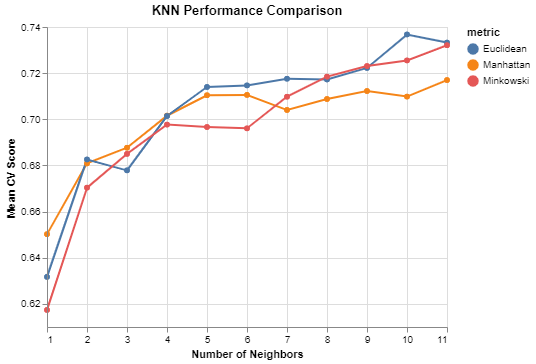

In [18]:
alt.Chart(results_KNN[results_KNN.rfi_fs__n_features_ == 10], 
           title='KNN Performance Comparison'
          ).mark_line(point=True).encode(
     alt.X('knn__n_neighbors', title='Number of Neighbors'),
     alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False)),
     color='metric'
    )

## (Gaussian) Naive Bayes (NB)<a class="anchor" id="6.2"></a><br>

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
np.random.seed(333)
x_transformed = PowerTransformer().fit_transform(D_train)
pipe_NB = Pipeline([('rfi_fs', RFIFeatureSelector()), 
                     ('nb', GaussianNB())])

params_pipe_NB = {'rfi_fs__n_features_': [1,2,3,4,5,6,7,8,9,10,11],
                  'nb__var_smoothing': np.logspace(0,-9, num=100)}

n_iter_search = 20
gs_pipe_NB = RandomizedSearchCV(estimator=pipe_NB, 
                          param_distributions=params_pipe_NB, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring=scoring_metric,
                          n_iter=n_iter_search,
                          verbose=1) 

gs_pipe_NB.fit(x_transformed, t_train);
print(gs_pipe_NB.best_params_)
print(gs_pipe_NB.best_score_)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  82 tasks      | elapsed:    3.5s


{'rfi_fs__n_features_': 7, 'nb__var_smoothing': 0.23101297000831597}
0.7415692007797271


[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:   12.8s finished


We observe that the optimal mean recall score is 0.74 with 7 features and a variable smoothing of 0.231.

In [20]:
results_NB = pd.DataFrame(gs_pipe_NB.cv_results_['params'])
results_NB['test_score'] = gs_pipe_NB.cv_results_['mean_test_score']

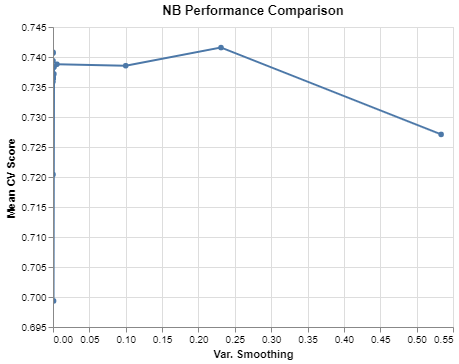

In [21]:
alt.Chart(results_NB, 
          title='NB Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('nb__var_smoothing', title='Var. Smoothing'),
    alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False))
).interactive()

## Decision Tree (DT)<a class="anchor" id="6.3"></a><br>

In [37]:
from sklearn.tree import DecisionTreeClassifier
np.random.seed(333)
pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='gini'))])

params_pipe_DT = {'rfi_fs__n_features_': [1,2,3,4,5,6,7,8,9,10,Data.shape[1]],
                  'dt__max_depth': [1,2,3,4,5,6,7],
                  'dt__min_samples_split': [20,50,70,100]}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring=scoring_metric,
                          verbose=1) 

gs_pipe_DT.fit(D_train, t_train);
print(gs_pipe_DT.best_score_)
print(gs_pipe_DT.best_params_)

Fitting 15 folds for each of 308 candidates, totalling 4620 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-2)]: Done 794 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-2)]: Done 1244 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 1794 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 2444 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 3194 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 4044 tasks      | elapsed:  3.1min


0.722051656920078
{'dt__max_depth': 4, 'dt__min_samples_split': 70, 'rfi_fs__n_features_': 7}


[Parallel(n_jobs=-2)]: Done 4620 out of 4620 | elapsed:  3.5min finished


We observe that the optimal model for the Decision Tree is 0.722 with 7 features, 4 max depth and a minimum sample split of 70.

In [38]:
gs_pipe_DT_copy = gs_pipe_DT
gs_pipe_DT_copy = get_search_results(gs_pipe_DT)
gs_pipe_DT_copy.head()

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
160,0.722052,0.039787,0.808114,0.669956,4.0,70.0,7.0
138,0.720419,0.042587,0.811769,0.643275,4.0,20.0,7.0
202,0.719055,0.040729,0.796784,0.651681,5.0,70.0,5.0
158,0.718738,0.043262,0.831140,0.663012,4.0,70.0,5.0
292,0.717178,0.052912,0.823099,0.605263,7.0,70.0,7.0


Through the chart above we see that there very small gap between the quality of thr top model and the preceding models.

In [39]:
results_DT = pd.DataFrame(gs_pipe_DT.cv_results_['params'])
results_DT['test_score'] = gs_pipe_DT.cv_results_['mean_test_score']
results_DT.columns

Index(['dt__max_depth', 'dt__min_samples_split', 'rfi_fs__n_features_',
       'test_score'],
      dtype='object')

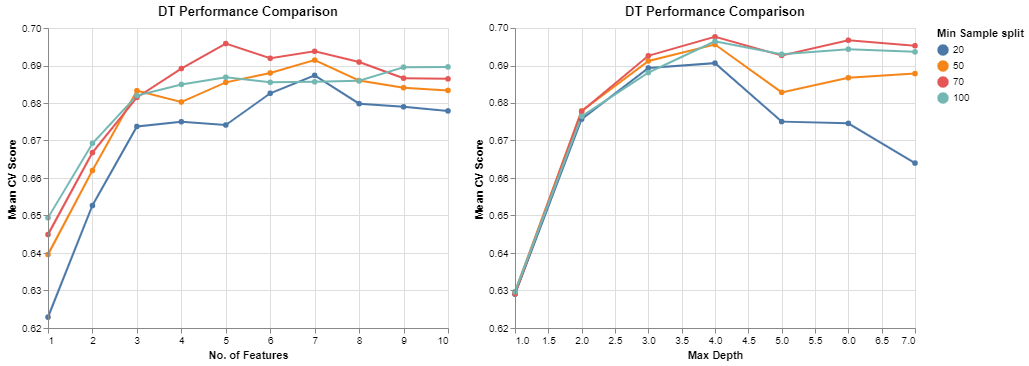

In [40]:
import altair as alt
alt.renderers.enable('notebook')
alt.Chart(results_DT, 
          title='DT Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('rfi_fs__n_features_', title='No. of Features'),
    alt.Y('test_score', title='Mean CV Score', aggregate='average', scale=alt.Scale(zero=False)),
    alt.Color('dt__min_samples_split:N', title='Min Sample split')
)| alt.Chart(results_DT, 
          title='DT Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('dt__max_depth', title='Max Depth'),
    alt.Y('test_score', title='Mean CV Score', aggregate='average', scale=alt.Scale(zero=False)),
    alt.Color('dt__min_samples_split:N')
)

# Performance Comparision<a class="anchor" id="7"></a><br>

Throgh cross validation we can generate a mean result of each model then compare them through a t-test to see which model is best suited at predicting the outcome with respect to the recall scoring metric.

In [41]:
cv_method_ttest = RepeatedStratifiedKFold(n_splits=10,  
                                          random_state=333)
cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=D_test,
                                 y=t_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring=scoring_metric)
cv_results_KNN.mean()

0.6921025641025642

In [42]:
cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=D_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring=scoring_metric)
cv_results_NB.mean()

0.7377083333333335

In [43]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT.best_estimator_,
                                X=D_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring=scoring_metric)
cv_results_DT.mean()

0.6433958333333334

In [44]:
from scipy import stats

print(stats.ttest_rel(cv_results_NB, cv_results_KNN))
print(stats.ttest_rel(cv_results_DT, cv_results_KNN))
print(stats.ttest_rel(cv_results_DT, cv_results_NB))

Ttest_relResult(statistic=4.475927888067043, pvalue=2.037315627599239e-05)
Ttest_relResult(statistic=-3.514255729773215, pvalue=0.0006665649861694179)
Ttest_relResult(statistic=-7.2495531137982825, pvalue=9.349971564541174e-11)


From the results of the above statistical test we can see that at the 95% significance level, the NB model is statistically the best model in terms of roc_auc when compared on the test data.

In [45]:
KNN_pred = gs_pipe_KNN.predict(D_test)
NB_pred = gs_pipe_NB.predict(D_test)
DT_pred = gs_pipe_DT.predict(D_test)

In [46]:
from sklearn import metrics
print(metrics.classification_report(t_test, KNN_pred))
print(metrics.classification_report(t_test, NB_pred))
print(metrics.classification_report(t_test, DT_pred))

              precision    recall  f1-score   support

           0       0.38      0.44      0.41        45
           1       0.79      0.74      0.77       129

   micro avg       0.67      0.67      0.67       174
   macro avg       0.59      0.59      0.59       174
weighted avg       0.69      0.67      0.67       174

              precision    recall  f1-score   support

           0       0.54      0.49      0.51        45
           1       0.83      0.85      0.84       129

   micro avg       0.76      0.76      0.76       174
   macro avg       0.68      0.67      0.68       174
weighted avg       0.75      0.76      0.75       174

              precision    recall  f1-score   support

           0       0.36      0.09      0.14        45
           1       0.75      0.95      0.84       129

   micro avg       0.72      0.72      0.72       174
   macro avg       0.56      0.52      0.49       174
weighted avg       0.65      0.72      0.66       174



In [47]:
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.confusion_matrix(t_test, KNN_pred))
print("\nClassification report for Naive Bayes") 
print(metrics.confusion_matrix(t_test, NB_pred))
print("\nClassification report for Decision Tree") 
print(metrics.confusion_matrix(t_test, DT_pred))


Classification report for K-Nearest Neighbor
[[20 25]
 [33 96]]

Classification report for Naive Bayes
[[ 22  23]
 [ 19 110]]

Classification report for Decision Tree
[[  4  41]
 [  7 122]]


We can see that both Naive Bayes and K-Nearest neighbours produce similar classification reports both been more well rounded allowing to more accurately classify if someone has the decease or not. though there is still some ambiguity about miss diagnosing a patient that has the decease. This is where the Decision tree model excels, with the highest recall score this model has 95% predict ability how ever the cost been that it will more likely miss diagnose that someone has the decease which could lead to legal ramifications.

# Critique<a class="anchor" id="8"></a><br>

The final product models generated could have had alterations made that could have potentially imporved the models. Starting with the feature selection and ranking.<br> 
When it came to feature selection to use I only chose to consider 3 different options and 1 for ranking, this been due to my lack of feature selection methods knowledge (FSM) as well as how to implement them into a pipeline. However in the future I would implement a great variety of FSM to allow for a more indepth analysis on which features to implement.<br>
Our Naives Bayes model was statistically better than its counterparts, however this model could have potentially been improved, if I chose to produce 2 separate models a Gaussian NB and a Bernoulli NB then multiple them toegether to produce a final prediction score, it may have produced a better result having better utilised the dummy variable in the data set.

# Summary & Conclusion<a class="anchor" id="9"></a><br>

The decision tree model with 3 of the best features calculated through the random forests importance (RFI) produced the highest cross validated recall score on the given training data. After testing 3 different feature selection methods and finding that mutual information produced slightly stronger results, I chose to use random forests (RF) as my feature selection method. Through RF the Naive Bayes model produced the the most accurate roc_auc model with respect to K-Nearest neighbours and Decision trees. Though the Decision tree model produced the greatest recall score, which is an important scoring method for trying to correctly predict liver decease while trying to minimise false diagnosing a patient who has cancer as otherwise.